In [34]:
import numpy as np
import pandas as pd
pd.set_option('colheader_justify', 'left')

import pandas_datareader.data as web
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.animation as animation

import requests

import time
import datetime

from mpl_finance import candlestick_ohlc

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.figsize'] = (16, 8)
# recet to matplotlib standards
#jtplot.reset()

# matplotlib overrides
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

# Color Scheme & Style

In [2]:
colors = {'background': '#262626',
          'font': 'w',
          'axis': 'w',
          'rsi': '00ffcc'}

# Macro variables

In [98]:
tickers = ['MSF.DE', 'AMZ.DE', 'CMC.DE', 'PFE.DE', 'CIS.DE', 'HDI.DE', 'MDO.DE', 
            'AEC1.DE', 'WDP.DE', 'JNJ.DE', '3V64.DE', 'BAS.DE', 'MMM.DE', 'UWS.F', 
            'WCN', 'RSG', 'BAC', 'NVD.DE', 'DBK.DE', 'KO', 'QCOM', 'BAC.DE', 'HC5.F',
            'KMB', 'MET', 'EA', 'ZNGA', 'GOOG', 'PAYC', 'AAPL', 'FB', 'TSLA', 'NFLX',
           'ATVI', 'BYND', 'PM', 'IIPR', 'BABA', 'DAI.DE']
    
indices = ['^NDX', '^GDAXI', '^MDAXI', '^GSPC', '^HSI']

etfs = ['C051.F', 'E903.DE', 'EXSG.DE', ]

exrs = ['EURUSD=X']

cryptos = []

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime.today()

# Calculate indicators

In [102]:
def calculate_indicators(ticker, df):
    #df = pd.read_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)

    # SIMPLE AVERAGES
    df['SMA 200'] = df['Close'].rolling(window=200).mean()
    df['SMA 21'] = df['Close'].rolling(window=21).mean()
    df['EMA 200'] = df['Close'].ewm(span=200, adjust=False).mean()
    df['EMA 50'] = df['Close'].ewm(span=50, adjust=False).mean()

    # BOLLINGER BANDS
    df['SD 21'] = df['Close'].rolling(window=21).std()
    df['Upper Band']= df['SMA 21']  + (df['SD 21'] * 2)
    df['Lower Band']= df['SMA 21']  - (df['SD 21'] * 2)


    # RSI
    n_rsi = 14

    df['Daily Difference'] = df['Close'].diff(1)

    df['Upward Movement'] = df['Daily Difference'].mask(df['Daily Difference']<0,0)
    df['Downward Movement'] = df['Daily Difference'].mask(df['Daily Difference']>0,0)

    df['Average Upward Movement'] = df['Upward Movement'].ewm(com=n_rsi-1, min_periods=n_rsi).mean()
    df['Average Downward Movement'] = df['Downward Movement'].ewm(com=n_rsi-1, min_periods=n_rsi).mean()

    df['Relative Strength'] = abs(df['Average Upward Movement'] / df['Average Downward Movement'])
    df['RSI'] = 100 - (100 / (1 + df['Relative Strength']))


    # MACD
    n_ema_fast = 12
    n_ema_slow = 26
    df['EMA Fast'] = df['Close'].ewm(n_ema_fast).mean()
    df['EMA Slow'] = df['Close'].ewm(n_ema_slow).mean()
    df['MACD'] = df['EMA Fast'] - df['EMA Slow']
    df['Signal'] = df['MACD'].ewm(9).mean()
    
    
    # STOCHASTIC OSCILATOR
    #find lowest and highest values for the last n days
    n =5
    df['L5'] = df['Low'].rolling(window=n).min()
    df['H5'] = df['High'].rolling(window=n).max()
    
    # n-period Stochastic Oscilliator
    df['%K'] = 100 * (df['Close'] - df['L5']) / (df['H5'] - df['L5'])
    df['%D'] = df['%K'].rolling(window=3).mean()
    
    
    # AVERAGE DIRECTIONAL INDICATOR
    smoothing_window = 14
    df['TR0'] = abs(df['High'] - df['Low'])
    df['TR1'] = abs(df['High'] - df['Close'].shift())
    df['TR2'] = abs(df['Low'] - df['Close'].shift())
    df['True Range'] = df[['TR0', 'TR1', 'TR2']].max(axis=1)
    
    df['Low Diff1'] = df['Low'].diff(1)
    df['Low Diff2'] = df['Low'].diff(-1)
    
    df['+DM1'] = 0
    df['-DM1'] = 0
    
    for i in range(1, len(df['Low'])):
        if df['High'].diff(1)[i] > df['Low'].diff(-1)[i-1]:
            df.iloc[i, df.columns.get_loc('+DM1')] = max(df['High'].diff(1)[i],0)
        else:
            0
            
        if df['Low'].diff(-1)[i-1] > df['High'].diff(1)[i]:
            df.iloc[i, df.columns.get_loc('-DM1')] = max(df['Low'].diff(-1)[i-1],0)
        else:
            0
    
    df['TR14'] = df['True Range'].ewm(smoothing_window).mean()
    df['+DM14'] =  df['+DM1'].ewm(smoothing_window).mean()
    df['-DM14'] =  df['-DM1'].ewm(smoothing_window).mean()
    df['+DI14'] =  100 * (df['+DM14'] / df['TR14'])
    df['-DI14'] =  100 * (df['-DM14'] / df['TR14'])
    df['DI Nominator'] = abs(df['+DM14'] - df['-DM14'])
    df['DI Denominator'] = df['+DM14'] + df['-DM14']
    df['DX'] = 100 * (df['DI Nominator'] / df['DI Denominator'])
    df['ADX'] = df['DX'].ewm(smoothing_window).mean()
        
    return df

#df = calculate_indicators('MSF.DE')
#df

# Data collection

In [3]:
import yfinance as yf

In [103]:
# YFINANCE
import yfinance as yf

def fetch_yfinance_data(ticker, start, end):

    try:
        print('Fetching {ticker} data...'.format(ticker=ticker))
        data = yf.Ticker(ticker)
        
        df = data.history(start=start, end=end)
        
        df = calculate_indicators(ticker, df)

        df.to_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', index=True, header=True)
        print('Fetching {ticker} data complete.'.format(ticker=ticker))
        time.sleep(2)

    except Exception as e:
        print('Fetch {ticker} data error: '.format(ticker=ticker), e)


def main():
    for ticker in tickers:
        fetch_yfinance_data(ticker, start, end)
        
        
main()

Fetching MSF.DE data...
Fetching MSF.DE data complete.
Fetching AMZ.DE data...
Fetching AMZ.DE data complete.
Fetching CMC.DE data...
Fetching CMC.DE data complete.
Fetching PFE.DE data...
Fetching PFE.DE data complete.
Fetching CIS.DE data...
Fetching CIS.DE data complete.
Fetching HDI.DE data...
Fetching HDI.DE data complete.
Fetching MDO.DE data...
Fetching MDO.DE data complete.
Fetching AEC1.DE data...
Fetching AEC1.DE data complete.
Fetching WDP.DE data...
Fetching WDP.DE data complete.
Fetching JNJ.DE data...
Fetching JNJ.DE data complete.
Fetching 3V64.DE data...
Fetching 3V64.DE data complete.
Fetching BAS.DE data...
Fetching BAS.DE data complete.
Fetching MMM.DE data...
Fetching MMM.DE data complete.
Fetching UWS.F data...
Fetching UWS.F data complete.
Fetching WCN data...
Fetching WCN data complete.
Fetching RSG data...
Fetching RSG data complete.
Fetching BAC data...
Fetching BAC data complete.
Fetching NVD.DE data...
Fetching NVD.DE data complete.
Fetching DBK.DE data...
Fe

# Find Dividends

Find all dividends of the watchlist

In [104]:


for i, ticker in enumerate(tickers):
    if i == 0:
        data = yf.Ticker(ticker)
        data.history(start=start, end=end)
        df_dividends = pd.DataFrame(data.dividends)
        df_dividends['Ticker'] = ticker
        df_dividends['Year'] = df_dividends.index.strftime('%Y')
        df_dividends['Month'] = df_dividends.index.strftime('%b')
        df_dividends['Month Year'] = df_dividends.index.strftime('%b-%Y')
        df = pd.read_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
        df_dividends = pd.merge(df_dividends, df['Close'], right_index=True, left_index=True, how='left')
        df_dividends['Dividend Yield'] = df_dividends['Dividends'] / df_dividends['Close'] * 100
        
    elif i != 0:
        try:
            data = yf.Ticker(ticker)
            data.history(start=start, end=end)
            df_dividends_temp = pd.DataFrame(data.dividends)
            df_dividends_temp['Ticker'] = ticker
            df_dividends_temp['Year'] = df_dividends_temp.index.strftime('%Y')
            df_dividends_temp['Month'] = df_dividends_temp.index.strftime('%b')
            df_dividends_temp['Month Year'] = df_dividends_temp.index.strftime('%b-%Y')
            df = pd.read_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
            df_dividends_temp = pd.merge(df_dividends_temp, df['Close'], right_index=True, left_index=True, how='left')
            df_dividends_temp['Dividend Yield'] = df_dividends_temp['Dividends'] / df_dividends_temp['Close'] * 100

            #combine with first df
            df_dividends = pd.concat([df_dividends, df_dividends_temp])
            
        except:
            pass

In [105]:
df_dividends

,Dividends,Ticker,Year,Month,Month Year,Close,Dividend Yield
Date,,,,,,,
2017-02-14,0.39,MSF.DE,2017,Feb,Feb-2017,57.68,0.676144
2017-05-16,0.39,MSF.DE,2017,May,May-2017,59.38,0.656787
2017-08-15,0.39,MSF.DE,2017,Aug,Aug-2017,59.92,0.650868
2017-11-15,0.42,MSF.DE,2017,Nov,Nov-2017,68.29,0.615024
2018-02-14,0.42,MSF.DE,2018,Feb,Feb-2018,70.30,0.597440
2018-05-16,0.42,MSF.DE,2018,May,May-2018,80.34,0.522778
2018-08-15,0.42,MSF.DE,2018,Aug,Aug-2018,93.41,0.449631
2018-11-14,0.46,MSF.DE,2018,Nov,Nov-2018,92.10,0.499457
2019-02-20,0.46,MSF.DE,2019,Feb,Feb-2019,93.78,0.490510


In [81]:
years = list(set(df_dividends['Year']))
years = [int(year) for year in years]
years.sort()
years = [str(year) for year in years]
years

months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

dividend_dates = []
for year in years:
    for month in months:
        dividend_dates.append('{month}-{year}'.format(month=month, year=year))

for t, ticker in enumerate(tickers):
    if t == 0:
        df_dividends_sorted = pd.DataFrame(columns=dividend_dates, index=tickers)
                
    elif t != 0:
        pass
    
    for date in dividend_dates:
        if len(list(df_dividends[(df_dividends['Ticker']==ticker) & (df_dividends['Month Year']==date)]['Dividends'])) != 0:
            df_dividends_sorted[date][ticker] = list(df_dividends[(df_dividends['Ticker']==ticker) & (df_dividends['Month Year']==date)]['Dividends']).pop()
        else:
            df_dividends_sorted[date][ticker] = None
            
df_dividends_sorted


,Jan-2017,Feb-2017,Mar-2017,Apr-2017,May-2017,Jun-2017,Jul-2017,Aug-2017,Sep-2017,Oct-2017,...,Mar-2019,Apr-2019,May-2019,Jun-2019,Jul-2019,Aug-2019,Sep-2019,Oct-2019,Nov-2019,Dec-2019
MSF.DE,None,0.39,None,None,0.39,None,None,0.39,None,None,...,None,None,0.46,None,None,None,None,None,None,None
AMZ.DE,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
CMC.DE,0.48,None,None,0.5,None,None,0.5,None,None,0.56,...,None,0.8,None,None,0.8,None,None,None,None,None
PFE.DE,None,0.32,None,None,0.32,None,None,0.32,None,None,...,None,None,0.36,None,None,0.36,None,None,None,None
CIS.DE,0.26,None,None,0.29,None,None,0.29,None,None,0.29,...,None,0.35,None,None,0.35,None,None,None,None,None
HDI.DE,None,None,0.89,None,0.89,None,None,0.89,None,None,...,1.36,None,None,1.36,None,None,None,None,None,None
MDO.DE,None,0.94,None,None,None,0.94,None,0.94,None,None,...,None,None,1.16,None,None,None,None,None,None,None
AEC1.DE,0.32,None,None,0.32,None,None,0.32,None,None,0.35,...,None,0.39,None,None,0.39,None,None,None,None,None
WDP.DE,None,None,None,None,None,None,0.78,None,None,None,...,None,None,None,None,0.88,None,None,None,None,None
JNJ.DE,None,None,None,None,None,None,None,None,None,None,...,None,None,0.95,None,None,None,None,None,None,None


In [82]:
# GET STOCK INFP
def get_symbol(symbol):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)

    result = requests.get(url).json()

    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']

get_symbol("AMZ.DE")

'Amazon.com, Inc.'

# Fundamental Analyse

In [97]:
def create_summary(tickers):
    
    headers = ['Name', 
               #'Statement Date', 
               'Currency',
               'Previous Close',
               'Open',
               'Price',
               'Daily Change',
               'Day Range',
               '52 Week Low',
               '52 Week High',
               'Market Cap', 
               'Equity Ratio', 
               'Annualized Dividend Yield', 
               'Annual Dividend Rate', 
               'Annualized EPS', 
               'P/E Ratio', 
               'P/B Ratio', 
               'P/C Ratio'] 
    
    # create empty dataframe
    df = pd.DataFrame(columns=headers, index=tickers)
    
    # fill data frame
    for ticker in tickers:
        
        try:
            data = yf.Ticker(ticker)
            divs = data.dividends
            bs = data.balance_sheet
            fins = data.financials
            info = data.info
        
        except:
            continue
        
        for header in headers:
            
            try:
                if header == 'Name':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = get_symbol(ticker)

                elif header == 'Statement Date':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = datetime.datetime.strptime(bs.columns[0], '%m/%d/%Y').strftime('%d.%m.%Y')
                    
                elif header == 'Currency':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = info['currency']
                    
                elif header == 'Previous Close':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = info['regularMarketPreviousClose']
                    
                elif header == 'Open':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = info['regularMarketOpen']
                                  
                elif header == 'Daily Change':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = info['regularMarketChange']
                
                elif header == 'Day Range':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = info['regularMarketDayRange']
                    
                elif header == '52 Week Low':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = info['fiftyTwoWeekLow']
                
                elif header == '52 Week High':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = info['fiftyTwoWeekHigh']
        
                elif header == 'Market Cap':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = round(info['marketCap'] / 1000000000, 2)

                elif header == 'Equity Ratio':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = round(int(bs.iloc[bs.index.get_loc('Total stockholders\' equity'), 0]) / int(bs.iloc[bs.index.get_loc('Total Assets'), 0 ]), 4)

                elif header == 'Annualized Dividend Yield':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = round(info['trailingAnnualDividendYield'] * 100, 4)

                elif header == 'Annual Dividend Rate':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = round(info['trailingAnnualDividendRate'], 2)

                elif header == 'P/E Ratio':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = round(info['trailingPE'], 4)

                elif header == 'Annualized EPS':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = round(info['epsTrailingTwelveMonths'], 4)

                elif header == 'P/B Ratio':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = round(info['priceToBook'], 4)

                elif header == 'P/C Ratio':
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = round(info['marketCap'] / int(fins.iloc[fins.index.get_loc('Net Income From Continuing Ops'), 0]), 2)

                else:
                    df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = 0
                    
            except:
                df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = None
                
    
    df.to_csv('./watchlist_summary.csv', sep=';', index=True, header=True)
    
    return df

df_summary = create_summary(tickers)
df_summary

,Name,Currency,Previous Close,Open,Price,Daily Change,Day Range,52 Week Low,52 Week High,Market Cap,Equity Ratio,Annualized Dividend Yield,Annual Dividend Rate,Annualized EPS,P/E Ratio,P/B Ratio,P/C Ratio
MSF.DE,Microsoft Corporation,EUR,123.1,124.1,0,0.900002,123.18 - 124.22,85.07,127.6,941.2,0.3571,1.4947,1.84,5.06,24.5059,9.2613,23985.7
AMZ.DE,"Amazon.com, Inc.",EUR,1620.4,1640,0,14.6,1630.8 - 1640.8,1233.78,1807.4,806.64,0.2677,None,None,24.104,67.8311,15.2219,80079.6
CMC.DE,JPMorgan Chase & Co.,EUR,97.93,98.89,0,0.959999,98.89 - 98.89,82.21,106,316.09,0.0879,3.2676,3.2,9.781,10.1104,1.3384,9733.7
PFE.DE,Pfizer Inc.,EUR,32,31.8,0,-0.199999,31.6 - 31.8,31.4,41.49,173.61,0.3976,4.375,1.4,2.164,14.6026,2.9513,15529.6
CIS.DE,"Cisco Systems, Inc.",EUR,47.035,47.205,0,0.134998,47.205 - 47.205,36.2,52.05,201.92,0.3972,2.8489,1.34,2.882,16.4105,5.5426,1.83561e+06
HDI.DE,"The Home Depot, Inc.",EUR,184.5,185.34,0,1.53999,183.92 - 186.66,143.73,196.08,203.38,-0.0427,2.5908,4.78,9.932,18.7314,-95.6012,18287.7
MDO.DE,McDonald's Corporation,EUR,195.86,196.98,0,0.559998,196.98 - 196.98,134.06,198.74,149.03,-0.1907,2.2925,4.49,7.614,25.8261,-22.9211,25155.7
AEC1.DE,American Express Company,EUR,111.16,109.72,0,-1.44,109.72 - 109.72,80.35,116.74,92.23,0.1182,1.4034,1.56,8.085,13.5708,3.9532,13326.3
WDP.DE,The Walt Disney Company,EUR,122.36,122.98,0,0.620003,122.98 - 122.98,90.19,132.12,220.25,0.4947,1.4384,1.76,7.767,15.8337,2.421,16856.9
JNJ.DE,Johnson & Johnson,EUR,119.34,119.76,0,0.420006,119.76 - 119.76,108.21,130.9,315.34,0.3907,3.0585,3.65,6.021,19.8904,5.2054,20614.5


In [308]:
data = yf.Ticker('CMC.DE')
divs = data.dividends
list(divs[-4:])

[0.8, 0.8, 0.8, 0.8]

In [ ]:
data.info

# Fast Plotting

In [125]:
df = df.tail(100)

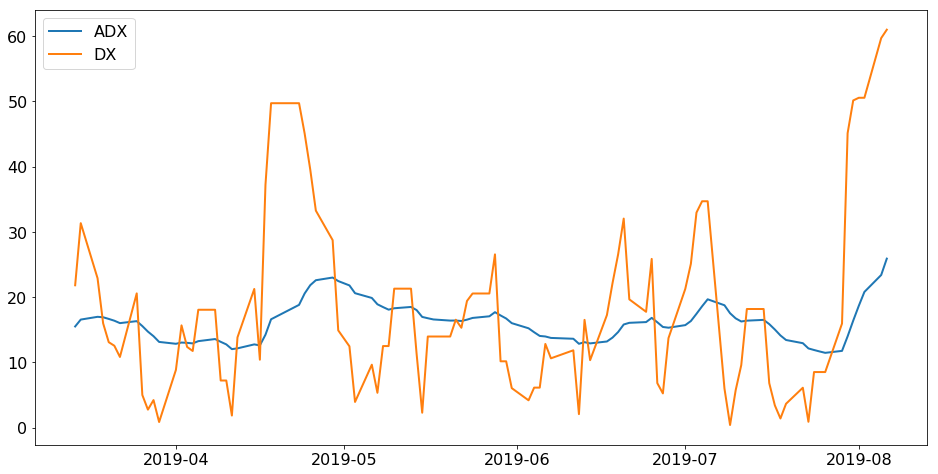

In [126]:
plt.plot(df.index, df['ADX'], label='ADX')
plt.plot(df.index, df['DX'], label='DX')
plt.legend(loc='upper left')
plt.show()

# Strong plot

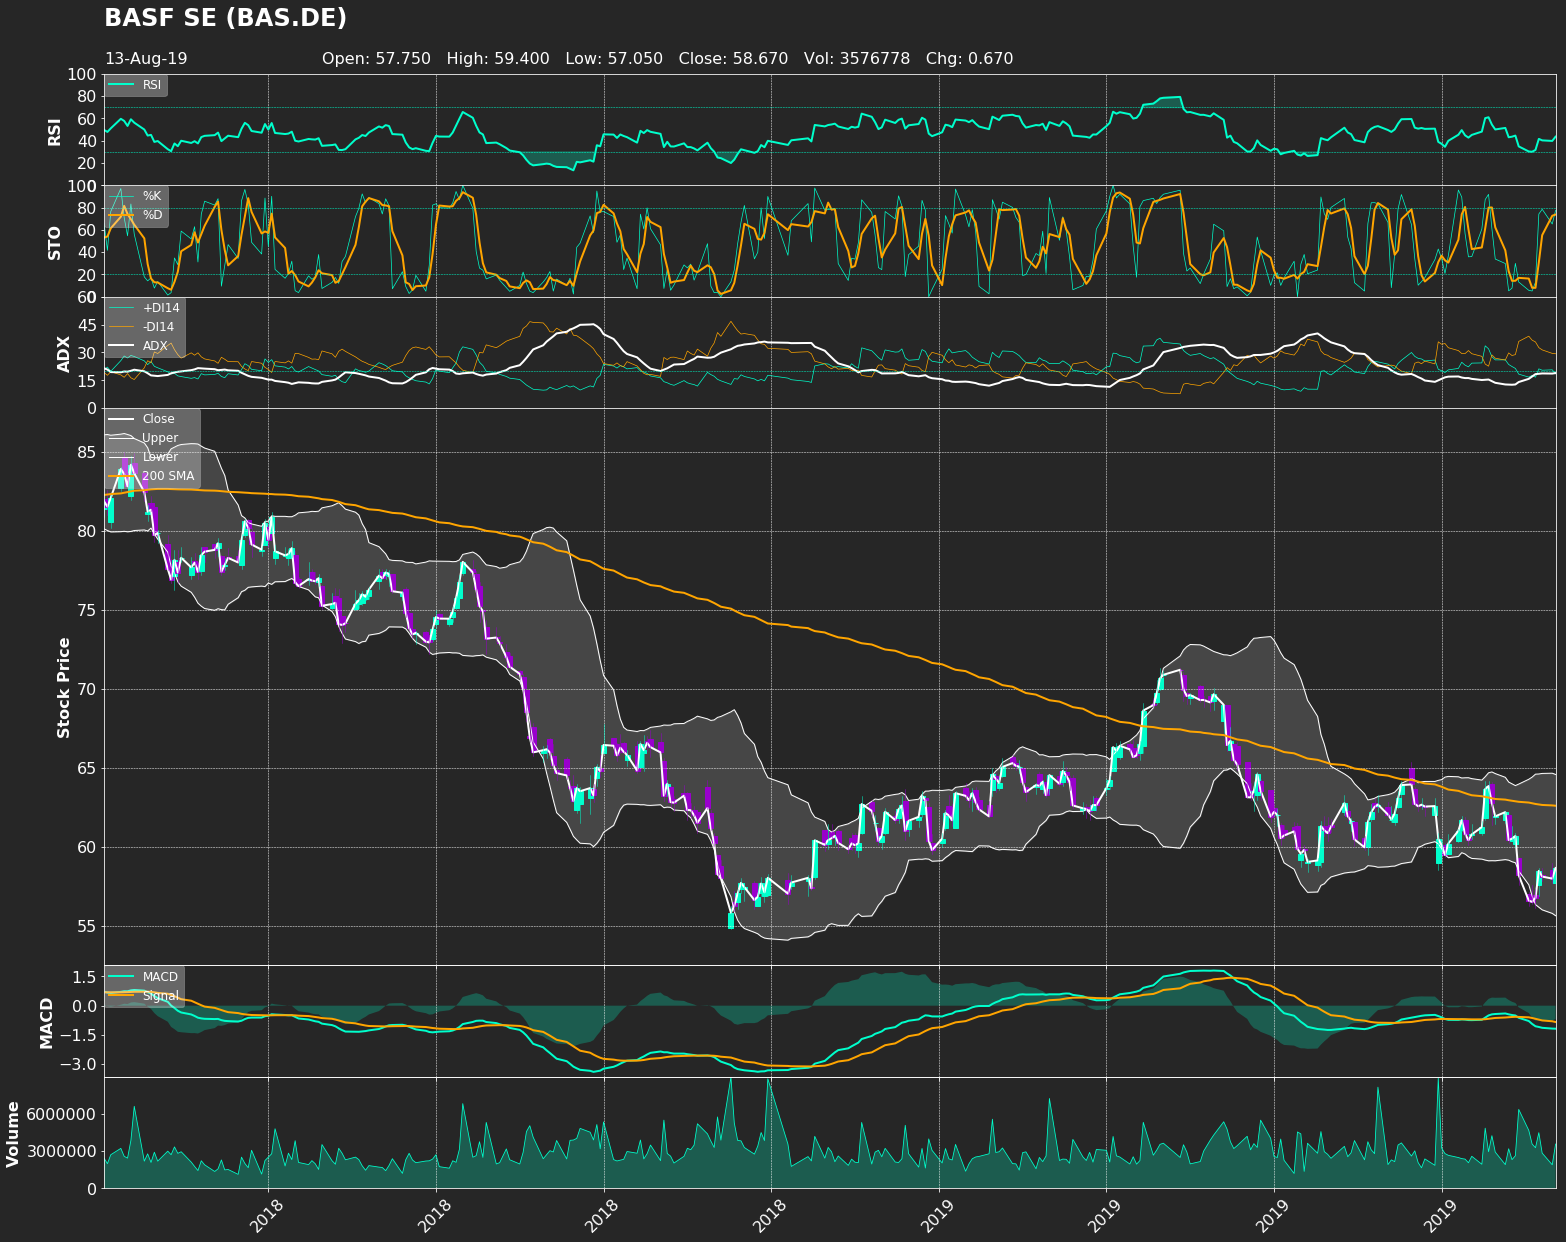

In [96]:
def plot_ticker(ticker, history=120):
    
    df = calculate_indicators(ticker)
    df = df.tail(history)
    
    # INITIALIZE FIGURE
    fig = plt.figure(figsize=(24, 18), facecolor='#262626')
    
    # AX5 VOLUME PLOT
    ax6 = plt.subplot2grid((10, 5), (9, 0), rowspan=1, colspan=5, facecolor='#262626')
    ax6.plot(df.index.date, df['Volume'], color='#00ffcc', linewidth=.8)
    ax6.fill_between(df.index.date, 0, df['Volume'], facecolor='#00ffcc', alpha=.25)
    ax6.yaxis.set_major_locator(mticker.MaxNLocator(3, prune='upper'))
    ax6.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
    ax6.spines['bottom'].set_color('w')
    ax6.spines['top'].set_color('w')
    ax6.spines['left'].set_color('w')
    ax6.spines['right'].set_color('w')
    #ax6.set_ylim(0, 6*df.Volume.max())
    ax6.tick_params(axis='both', colors='w')
    ax6.margins(y=0, tight=True)
    ax6.set_xlim(min(df.index.date), max(df.index.date))
    ax6.format_xdata = mdates.DateFormatter('%m-%Y')
    plt.ylabel('Volume', color='w')

    # label rotation
    for label in ax6.xaxis.get_ticklabels():
        label.set_rotation(45)
        # plt.xlabel('Date')


    # AX4 MACD PLOT
    ax5 = plt.subplot2grid((10, 5), (8, 0), sharex=ax6, rowspan=1, colspan=5, facecolor='#262626')
    #ax5.plot(df.index.date, df.Volume, color='#00ffcc', linewidth=.8)
    #ax5.fill_between(df.index.date, 0, df.Volume, facecolor='#00ffcc', alpha=.25)
    ax5.plot(df.index.date, df['MACD'], label='MACD', color='#00ffcc')
    ax5.plot(df.index.date, df['Signal'], label='Signal', color='orange')
    ax5.fill_between(df.index.date, (df['MACD']-df['Signal'])*2, facecolor='#00ffcc', alpha=.25)
    ax5.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='upper'))
    ax5.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
    ax5.spines['bottom'].set_color('w')
    ax5.spines['top'].set_color('w')
    ax5.spines['left'].set_color('w')
    ax5.spines['right'].set_color('w')
    ax5.tick_params(axis='both', colors='w')
    ax5.yaxis.label.set_color('w')
    ax5.xaxis.label.set_color('w')
    ax5.axes.xaxis.set_visible(True)
    plt.setp(ax5.get_xticklabels(), visible=False)
    plt.ylabel('MACD', color='w')
    legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
    legend.get_frame().set_alpha(0.3)
    legend_text = plt.gca().get_legend().get_texts()
    plt.setp(legend_text[0:5], color='w')


    # AX1 RSI PLOT  
    ax1 = plt.subplot2grid((10, 5), (0, 0), sharex=ax5, rowspan=1, colspan=5, facecolor='#262626')
    ax1.plot(df.index.date, df['RSI'], label='RSI', color='#00ffcc')
    ax1.axhline(70, color='#00ffcc', linewidth=.5, linestyle='--')
    ax1.axhline(30, color='#00ffcc', linewidth=.5, linestyle='--')
    ax1.fill_between(df.index.date, df['RSI'], 70, where=(df['RSI']>=70), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
    ax1.fill_between(df.index.date, df['RSI'], 30, where=(df['RSI']<=30), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
    ax1.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
    ax1.spines['bottom'].set_color('w')
    ax1.spines['top'].set_color('w')
    ax1.spines['left'].set_color('w')
    ax1.spines['right'].set_color('w')
    ax1.set_ylim(0,100)
    ax1.tick_params(axis='both', colors='w')
    ax1.yaxis.label.set_color('w')
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.yaxis.set_major_locator(mticker.MaxNLocator(5))
    plt.ylabel('RSI', color='w')
    legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
    legend.get_frame().set_alpha(0.3)
    legend_text = plt.gca().get_legend().get_texts()
    plt.setp(legend_text[0:5], color='w')


    # AX2 STOCHASTIC OSCILATOR PLOT  
    ax2 = plt.subplot2grid((10, 5), (1, 0), sharex=ax5, rowspan=1, colspan=5, facecolor='#262626')
    ax2.plot(df.index.date, df['%K'], label='%K', color='#00ffcc', linewidth=0.7)
    ax2.plot(df.index.date, df['%D'], label='%D', color='orange')
    ax2.axhline(80, color='#00ffcc', linewidth=.5, linestyle='--')
    ax2.axhline(20, color='#00ffcc', linewidth=.5, linestyle='--')
    ax2.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
    ax2.spines['bottom'].set_color('w')
    ax2.spines['top'].set_color('w')
    ax2.spines['left'].set_color('w')
    ax2.spines['right'].set_color('w')
    ax2.set_ylim(0,100)
    ax2.tick_params(axis='both', colors='w')
    ax2.yaxis.label.set_color('w')
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.yaxis.set_major_locator(mticker.MaxNLocator(5))
    plt.ylabel('STO', color='w')
    legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
    legend.get_frame().set_alpha(0.3)
    legend_text = plt.gca().get_legend().get_texts()
    plt.setp(legend_text[0:5], color='w')
    
    
    # AX3 ADX PLOT
    ax3 = plt.subplot2grid((10, 5), (2, 0), sharex=ax5, rowspan=1, colspan=5, facecolor='#262626')
    ax3.plot(df.index.date, df['+DI14'], label='+DI14', color='#00ffcc', linewidth=0.7)
    ax3.plot(df.index.date, df['-DI14'], label='-DI14', color='orange', linewidth=0.7)
    ax3.plot(df.index.date, df['ADX'], label='ADX', color='w')
    ax3.axhline(20, color='#00ffcc', linewidth=.5, linestyle='--')
    ax3.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
    ax3.spines['bottom'].set_color('w')
    ax3.spines['top'].set_color('w')
    ax3.spines['left'].set_color('w')
    ax3.spines['right'].set_color('w')
    ax3.set_ylim(0,60)
    ax3.tick_params(axis='both', colors='w')
    ax3.yaxis.label.set_color('w')
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax3.yaxis.set_major_locator(mticker.MaxNLocator(5))
    plt.ylabel('ADX', color='w')
    legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
    legend.get_frame().set_alpha(0.3)
    legend_text = plt.gca().get_legend().get_texts()
    plt.setp(legend_text[0:5], color='w')


    # AX3 CANDLESTICK + BOLLINGER BANDS PLOT
    ax4 = plt.subplot2grid((10, 5), (3, 0), sharex=ax5, rowspan=5, colspan=5, facecolor='#262626')
    ax4.plot(df.index.date, df['Close'], label='Close', color='w')
    ax4.grid(True, color='white', linewidth=.5, linestyle='--')
    ax4.xaxis.set_major_locator(mticker.MaxNLocator(10, prune='upper'))
    ax4.spines['bottom'].set_color('w')
    ax4.spines['top'].set_color('w')
    ax4.spines['left'].set_color('w')
    ax4.spines['right'].set_color('w')
    ax4.tick_params(axis='both', colors='w')
    ax4.yaxis.label.set_color('w')
    ax4.axes.xaxis.set_visible(True)
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.ylabel('Stock Price')

    # plot bollinger bands
    ax4.plot(df.index.date, df['Upper Band'], label='Upper', color='w', linewidth=1)
    ax4.plot(df.index.date, df['Lower Band'], label='Lower', color='w', linewidth=1)
    ax4.fill_between(df.index.date, df['Upper Band'], df['Lower Band'], color='w', alpha=0.15)

    # candlestick chart
    x=0
    y=len(df.index.date)
    arr = []
    while x<y:
        a = df.index.date[x].toordinal(), df.Open[x], df.High[x], df.Low[x], df.Close[x], df.Volume[x]
        arr.append(a)
        x += 1
    candlestick_ohlc(ax4, arr, width=1.5, colorup='#00ffcc', colordown='#9900cc')

    # plot averages
    #ax3.plot(df.index.date, df['SMA 21'], label='21 SMA', color='w')
    ax4.plot(df.index.date, df['SMA 200'], label='200 SMA', color='orange')
    legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
    legend.get_frame().set_alpha(0.3)
    legend_text = plt.gca().get_legend().get_texts()
    plt.setp(legend_text[0:5], color='w')


    # FIGURE TITLE AND FORMATTING OVERALL
    #plt.suptitle('{ticker}'.format(ticker=ticker), color='w', horizontalalignment='left')
    ax1.text(0, 1.6, '{info} ({ticker})'.format(ticker=ticker, info=get_symbol(ticker)), 
             horizontalalignment='left', verticalalignment='top', color='w', fontsize=24, fontweight='bold', transform=ax1.transAxes)
    ax1.text(0, 1.2, '{}'.format(df.tail(1).index.strftime('%d-%b-%y')[0]), 
             horizontalalignment='left', verticalalignment='top', color='w', transform=ax1.transAxes)
    ax1.text(0.15, 1.2, 'Open: {0:.3f}   High: {1:.3f}   Low: {2:.3f}   Close: {3:.3f}   Vol: {4}   Chg: {5:.3f}'.format(df.Open[-1], 
                                                                                                                         df.High[-1], 
                                                                                                                         df.Low[-1], 
                                                                                                                         df.Close[-1],
                                                                                                                         df.Volume[-1],
                                                                                                                         df.Close.diff(1)[-1]),
             horizontalalignment='left', verticalalignment='top', color='w', transform=ax1.transAxes)
    plt.subplots_adjust(left=0.1, bottom=0.09, right=0.94, top=0.95, wspace=0.20, hspace=0)

    plt.savefig('./img/{ticker}.png'.format(ticker=ticker), facecolor=fig.get_facecolor())

    return plt.show()


ticker = 'BAS.DE'
history = 300
plot_ticker(ticker, history)

# Older code

In [ ]:
df = df.tail(200)
    
# INITIALIZE FIGURE
fig = plt.figure(figsize=(16,20), facecolor='#262626')

    
# AX4 VOLUME PLOT
ax4 = plt.subplot2grid((8, 4), (7, 0), rowspan=1, colspan=4, facecolor='#262626')
ax4.plot(df.index.date, df['Volume'], color='#00ffcc', linewidth=.8)
ax4.fill_between(df.index.date, 0, df['Volume'], facecolor='#00ffcc', alpha=.25)
ax4.yaxis.set_major_locator(mticker.MaxNLocator(2, prune='upper'))
ax4.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
ax4.spines['bottom'].set_color('w')
ax4.spines['top'].set_color('w')
ax4.spines['left'].set_color('w')
ax4.spines['right'].set_color('w')
#ax4.set_ylim(0, 6*df.Volume.max())
ax4.tick_params(axis='both', colors='w')
ax4.margins(y=0, tight=True)
plt.ylabel('Volume', color='w')
        
# label rotation
for label in ax4.xaxis.get_ticklabels():
    label.set_rotation(45)
    # plt.xlabel('Date')
    
    
# AX3 MACD PLOT
ax3 = plt.subplot2grid((8,4), (6, 0), sharex=ax4, rowspan=1, colspan=4, facecolor='#262626')
#ax3.plot(df.index.date, df.Volume, color='#00ffcc', linewidth=.8)
#ax3.fill_between(df.index.date, 0, df.Volume, facecolor='#00ffcc', alpha=.25)
ax3.plot(df.index.date, df['MACD'])
ax3.plot(df.index.date, df['Signal'])
ax3.fill_between(df.index.date, (df['MACD']-df['Signal'])*2, facecolor='#00ffcc', alpha=.25)
ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='upper'))
ax3.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
ax3.spines['bottom'].set_color('w')
ax3.spines['top'].set_color('w')
ax3.spines['left'].set_color('w')
ax3.spines['right'].set_color('w')
ax3.tick_params(axis='both', colors='w')
ax3.yaxis.label.set_color('w')
ax3.xaxis.label.set_color('w')
ax3.axes.xaxis.set_visible(True)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.ylabel('MACD')
legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
legend.get_frame().set_alpha(0.3)
legend_text = plt.gca().get_legend().get_texts()
plt.setp(legend_text[0:5], color='w')


# AX1 RSI PLOT  
ax1 = plt.subplot2grid((8, 4), (0, 0), sharex=ax4, rowspan=1, colspan=4, facecolor='#262626')
ax1.plot(df.index.date, df['RSI'], color='#00ffcc')
ax1.axhline(70, color='#00ffcc', linewidth=.5, linestyle='--')
ax1.axhline(30, color='#00ffcc', linewidth=.5, linestyle='--')
ax1.fill_between(df.index.date, df['RSI'], 70, where=(df['RSI']>=70), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
ax1.fill_between(df.index.date, df['RSI'], 30, where=(df['RSI']<=30), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
ax1.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
ax1.spines['bottom'].set_color('w')
ax1.spines['top'].set_color('w')
ax1.spines['left'].set_color('w')
ax1.spines['right'].set_color('w')
ax1.set_ylim(0,100)
ax1.tick_params(axis='both', colors='w')
ax1.yaxis.label.set_color('w')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.yaxis.set_major_locator(mticker.MaxNLocator(5))
plt.ylabel('RSI', color='w')
   
    
# AX2 CANDLESTICK PLOT WITH VOLUME OVERLAY
# prepare data for candlestick chart
x=0
y=len(df.index.date)
arr = []
while x<y:
    a = df.index.date[x].toordinal(), df.Open[x], df.High[x], df.Low[x], df.Close[x], df.Volume[x]
    arr.append(a)
    x += 1

# plot candlestick chart
ax2 = plt.subplot2grid((8, 4), (1, 0), sharex=ax4, rowspan=5, colspan=4, facecolor='#262626')
ax2.plot(df.index.date, df['Upper Band'], label='Upper', color='w', linewidth=1)
ax2.plot(df.index.date, df['Lower Band'], label='Lower', color='w', linewidth=1)
ax2.fill_between(df.index.date, df['Upper Band'], df['Lower Band'], color='w', alpha=0.3)
candlestick_ohlc(ax2, arr, width=1, colorup='#00ffcc', colordown='#9900cc')
ax2.grid(True, color='white', linewidth=.5, linestyle='--')
ax2.xaxis.set_major_locator(mticker.MaxNLocator(10, prune='upper'))
ax2.spines['bottom'].set_color('w')
ax2.spines['top'].set_color('w')
ax2.spines['left'].set_color('w')
ax2.spines['right'].set_color('w')
ax2.tick_params(axis='both', colors='w')
ax2.yaxis.label.set_color('w')
ax2.axes.xaxis.set_visible(True)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Stock Price')
    
# plot averages
#ax2.plot(df.index.date, df['SMA 21'], label='21 SMA', color='w')
ax2.plot(df.index.date, df['SMA 200'], label='200 SMA', color='orange')
legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
legend.get_frame().set_alpha(0.3)
legend_text = plt.gca().get_legend().get_texts()
plt.setp(legend_text[0:5], color='w')

    
# FIGURE TITLE AND FORMATTING OVERALL
#plt.suptitle('{ticker}'.format(ticker=ticker), color='w', horizontalalignment='left')
ax1.text(0, 1.6, '{info} ({ticker})'.format(ticker=ticker, info=get_symbol(ticker)), 
         horizontalalignment='left', verticalalignment='top', color='w', fontsize=24, fontweight='bold', transform=ax1.transAxes)
ax1.text(0, 1.2, '{}'.format(df.tail(1).index.strftime('%d-%b-%y')[0]), 
         horizontalalignment='left', verticalalignment='top', color='w', transform=ax1.transAxes)
ax1.text(0.15, 1.2, 'Open: {0:.3f}   High: {1:.3f}   Low: {2:.3f}   Close: {3:.3f}   Vol: {4}   Chg: {5:.3f}'.format(df.Open[-1], 
                                                                                                                     df.High[-1], 
                                                                                                                     df.Low[-1], 
                                                                                                                     df.Close[-1],
                                                                                                                     df.Volume[-1],
                                                                                                                    df.Close.diff(1)[-1]),
         horizontalalignment='left', verticalalignment='top', color='w', transform=ax1.transAxes)
plt.subplots_adjust(left=0.1, bottom=0.09, right=0.94, top=0.95, wspace=0.20, hspace=0)
    
plt.savefig('{ticker}.png'.format(ticker=ticker), facecolor=fig.get_facecolor())
plt.show()

In [ ]:
def create_summary(tickers):
    headers = ['Name', 'Statement Date', 'EKQ', 'Dividend Payout Ratio', 'Last Dividend Date', 'Last Dividend', 'Price Last Dividend', 'Dividend Tenor', 'Annualized Dividend Yield'] 
    
    df = pd.DataFrame(columns=headers, index=tickers)
    for ticker in tickers:
        data = yf.Ticker(ticker)
        divs = data.dividends
        bs = data.balance_sheet
        info = data.info
        
        for header in headers:
            if header == 'Name':
                df.iloc[df.index.get_loc(ticker)][ df.columns.get_loc(header)] = get_symbol(ticker)
            
            elif header == 'Statement Date':
                df.iloc[df.index.get_loc(ticker)][ df.columns.get_loc(header)] = datetime.datetime.strptime(bs.columns[0], '%m/%d/%Y').strftime('%d.%m.%Y')
                
            elif header == 'EKQ':
                df.iloc[df.index.get_loc(ticker)][ df.columns.get_loc(header)] = int(bs.iloc[bs.index.get_loc('Total stockholders\' equity'), 0]) / int(bs.iloc[bs.index.get_loc('Total Assets'), 0 ])
                
            elif header == 'Dividend Payout Ratio':
                try:
                    df.iloc[df.index.get_loc(ticker)][ df.columns.get_loc(header)] = 0#int(bs.iloc[bs.index.get_loc('Common Stock'), 0]) / ( int(bs.iloc[bs.index.get_loc('Retained Earnings'), 0]) 
                                                                                     #+ int(bs.iloc[bs.index.get_loc('Common Stock'), 0]) 
                                                                                     #+ int(bs.iloc[bs.index.get_loc('Other Stockholder Equity'), 0]) )
                except ValueError:
                    continue
                    
            elif header == 'Last Dividend Date':
                df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = datetime.datetime.strptime(str(divs.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%d.%m.%Y')
        
            elif header == 'Last Dividend':
                df.iloc[df.index.get_loc(ticker)][df.columns.get_loc(header)] = divs.iloc[-1]
                
            elif header == 'Price Last Dividend':
                parsed_index = datetime.datetime.strptime(str(divs.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
                df_lookup = pd.read_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
                
                df.iloc[df.index.get_loc(ticker)][ df.columns.get_loc(header)] = df_lookup.Close[df_lookup.index == parsed_index][0]
            
            elif header == 'Dividend Tenor':
                df_divs = pd.DataFrame(divs)
                df_length = len(df_divs.loc[df_divs.index.year==2018])
                
                if df_length == 4:
                    df.iloc[df.index.get_loc(ticker)][ df.columns.get_loc(header)] = 'quarterly'
                    
                elif df_length == 2:
                    df.iloc[df.index.get_loc(ticker)][ df.columns.get_loc(header)] = 'semi-annual'
                    
                elif df_length == 2:
                    df.iloc[df.index.get_loc(ticker)][ df.columns.get_loc(header)] = 'annual'
            
            elif header == 'Annualized Dividend Yield':
                
                if df.iloc[df.index.get_loc(ticker)]['Dividend Tenor'] == 'quarterly':
                    dates_length = 4
                    
                elif df.iloc[df.index.get_loc(ticker)]['Dividend Tenor'] == 'semi-annual':
                    dates_length = 2
                    
                elif df.iloc[df.index.get_loc(ticker)]['Dividend Tenor'] == 'annual':
                    dates_length = 1
                    
                df_lookup = pd.read_csv('../data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
                timestamps = list(divs.index[-dates_length:])
                dividends = list(divs[-dates_length:])
                prices = []
                    
                # find last four dividend dates and lookup payed dividends from that dates
                for timestamp in timestamps:
                    parsed_date = timestamp.strftime('%Y-%m-%d')
                    price = df_lookup.Close[df_lookup.index == parsed_date][0]
                    prices.append(price)
                        
                eps = [a/b for a,b in zip(dividends, prices)]
                df.iloc[df.index.get_loc(ticker)][ df.columns.get_loc(header)] = sum(eps) * 100
            
            else:
                df.iloc[ df.index.get_loc(ticker)][df.columns.get_loc(header)] = 0
    
    return df

df_overview = create_summary(tickers)
df_overview